KeyError: 'Neutral_Pct'

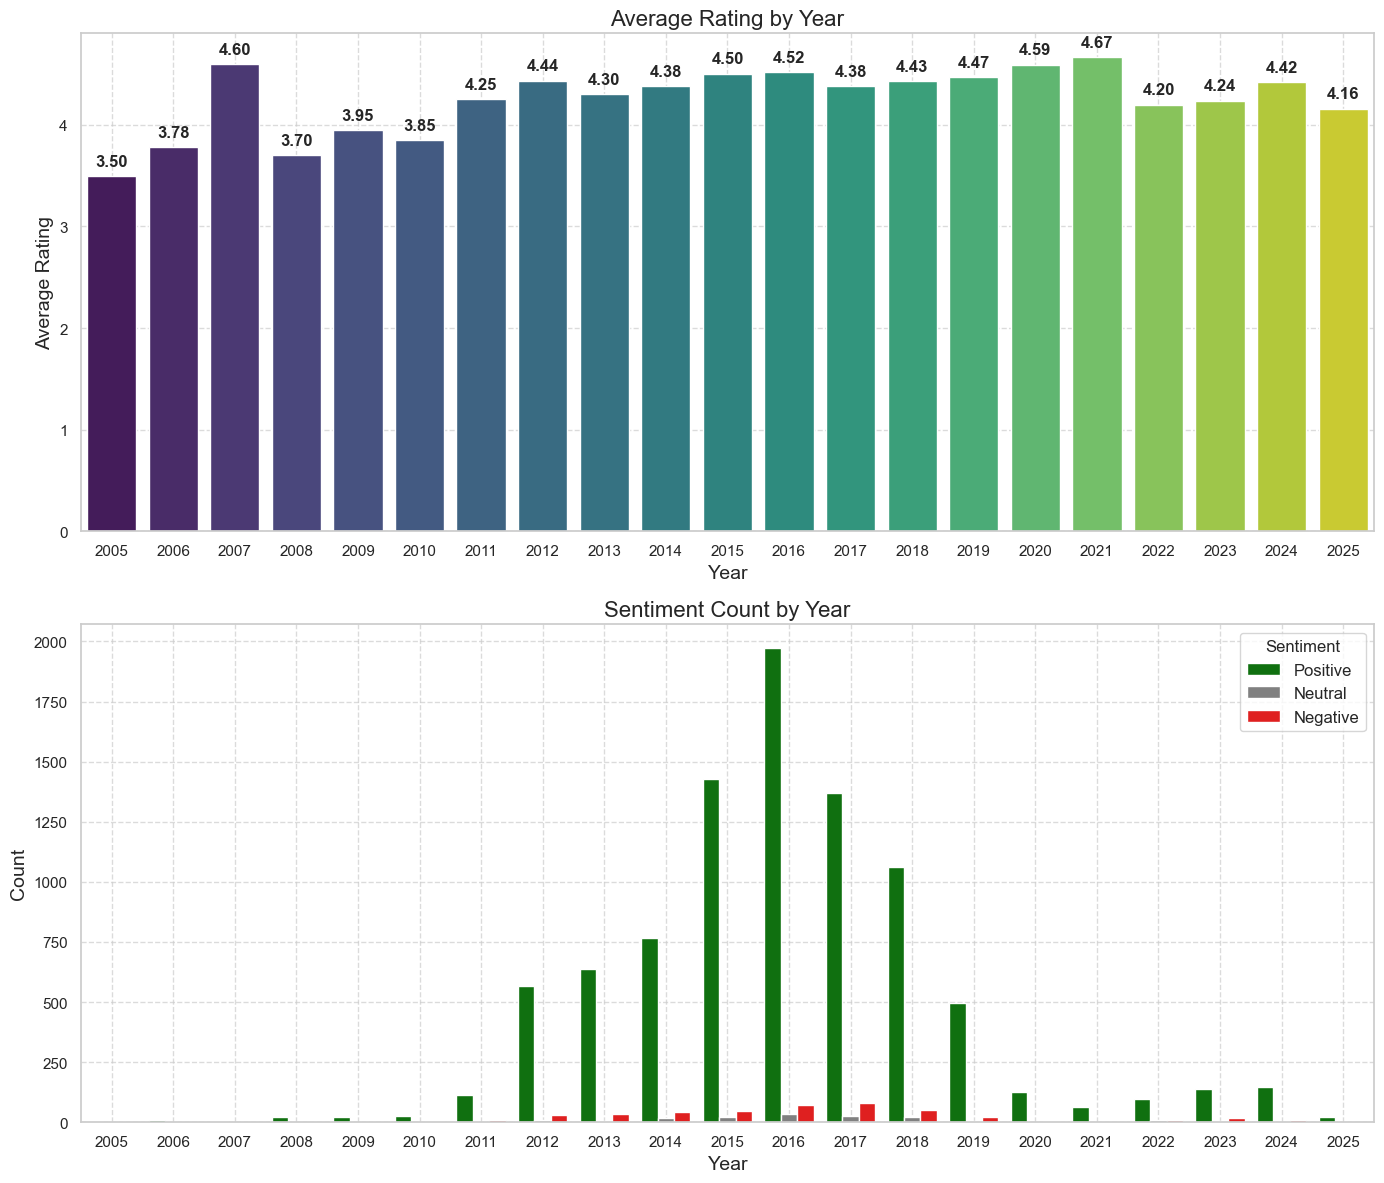

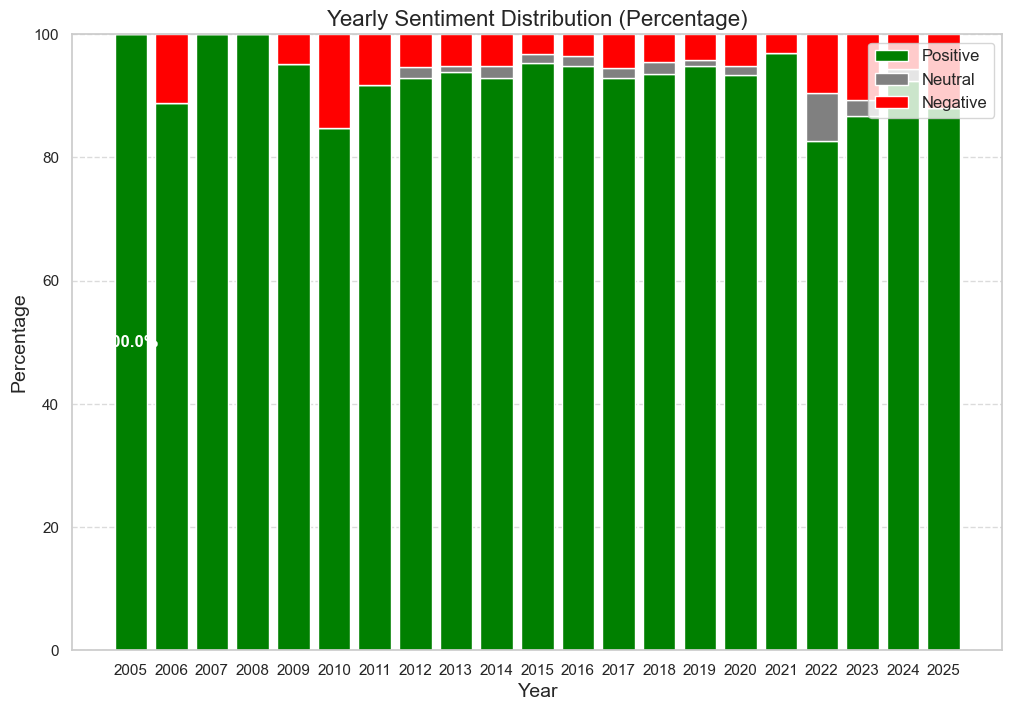

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from textblob import TextBlob
import re
import warnings
warnings.filterwarnings('ignore')

# Load the data
def load_data():
    try:
        # Try to read from the file system
        return pd.read_csv('clean_reviews.csv')
    except:
        # If that fails, just load the content directly
        import io
        data_str = """Location.Name,Title,Text,Rating,Year,Month,Day,Hometown,City,State_Country,Tourist_type
The_Museum_of_Modern_Art_MoMA,Well worth a visit,"Always worth a visit to see the collection, to say nothing of the special exhibitions. The layout is well-done and makes it easy to not only explore each floor but to easily travel between the floors. Also has pretty good in-museum dining.",5,2025,3,9,,NA,NA,NA
The_Museum_of_Modern_Art_MoMA,Simply love this place,"An absolute delight, totally worth the visit. As expected excellent art ++++ and a must for all interested art, if you can definitely visit here. A honour and privilege,",5,2025,3,8,"London, United Kingdom",London,United Kingdom,Foreign
The_Museum_of_Modern_Art_MoMA,More 'Shart' than 'Art',"Noting that art appreciation is subjective, there are a few lovely/notable art pieces (none of which I'd call 'modern'), but the majority of this museum screams 'Emperor's new clothes' vibes. Some of the ""art"" was laugh-out-loud ridiculous (whole main second floor gallery, I'm looking at you) and the crowds jostling around 'Starry Night' to get a good selfie while ignoring the gorgeous Cezannes right next to it sum up this experience.

If you're in NYC to do all the touristy things including seeing all of the main galleries then I guess you need to find this out for yourself, but if your time (or patience) is limited and you have to make some cuts to your itinerary then this is one I'd easily skip.",2,2025,3,5,"Tweed Heads, Australia",Tweed Heads,Australia,Foreign
The_Museum_of_Modern_Art_MoMA,Wonderful Museum,"Can't believe I saw Starry Night ✨

- Wonderful gift shop
- Great variety of well known artists
- Very spacious 
- Time went quickly as I was very fixated on the art",5,2025,3,2,"Birmingham, United Kingdom",Birmingham,United Kingdom,Foreign
The_Museum_of_Modern_Art_MoMA,Poorly managed museum with a great collection,"I am not an art expert, but love learning about art, which is why I was disappointed that the only way to learn about Moma's many fine pieces is with cell phone technology that is so poorly supported by the museum that it is useless and frustrating. After two hours of seeing some pieces and trying to get the technology to work (we tried the museums own system and the Bloomberg app. Neither worked and they didn't have old fashioned audio guides) we decided to take a break at the 2nd floor cafe. We ordered soup and sandwiches and waited. After about 25 minutes the server came back and eventually realized we didn't have food because she had not submitted our order. We went to get our things from coat check and that took a full 15 minutes, even with no line due to incompetence. We've been to museums all over the world and this one is, hands down, the most poorly organized. Next time we will go to the Met or the Whitney.",1,2025,3,1,"Baton Rouge, Louisiana",Baton Rouge,Louisiana,Domestic"""
        
        # Use only the first few lines as a sample for debugging
        return pd.read_csv(io.StringIO(data_str))

# Clean text
def clean_text(text):
    if isinstance(text, str):
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        return text
    return ''

# Classify sentiment based on rating
def classify_sentiment_by_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Calculate TextBlob sentiment
def get_textblob_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        # Return the polarity score (-1 to 1)
        return analysis.sentiment.polarity
    return 0

# Get VADER sentiment
def get_vader_sentiment(text):
    if isinstance(text, str):
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(text)
        return ss['compound']  # -1 to 1
    return 0

# Classify sentiment based on score
def classify_sentiment_by_score(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Main function
def main():
    # Load data
    df = load_data()
    
    # Drop rows with missing Year
    df = df.dropna(subset=['Year'])
    
    # Convert Year to numeric
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    
    # Drop rows with invalid Year
    df = df.dropna(subset=['Year'])
    
    # Clean the text
    df['Clean_Text'] = df['Text'].apply(clean_text)
    
    # Classify sentiment based on rating
    df['Rating_Sentiment'] = df['Rating'].apply(classify_sentiment_by_rating)
    
    # Get TextBlob sentiment
    df['TextBlob_Score'] = df['Text'].apply(get_textblob_sentiment)
    df['TextBlob_Sentiment'] = df['TextBlob_Score'].apply(classify_sentiment_by_score)
    
    # Get VADER sentiment
    df['VADER_Score'] = df['Text'].apply(get_vader_sentiment)
    df['VADER_Sentiment'] = df['VADER_Score'].apply(classify_sentiment_by_score)
    
    # Create a composite sentiment
    # Using a weighted average of TextBlob and VADER
    df['Composite_Score'] = (df['TextBlob_Score'] + df['VADER_Score']) / 2
    df['Composite_Sentiment'] = df['Composite_Score'].apply(classify_sentiment_by_score)
    
    # Group by Year only
    yearly_sentiment = df.groupby('Year').agg({
        'Rating': 'mean',
        'TextBlob_Score': 'mean',
        'VADER_Score': 'mean',
        'Composite_Score': 'mean'
    }).reset_index()
    
    # Count sentiments by year
    yearly_counts = df.groupby('Year')['Composite_Sentiment'].value_counts().unstack(fill_value=0).reset_index()
    
    # Merge the two dataframes
    yearly_analysis = pd.merge(yearly_sentiment, yearly_counts, on='Year', how='left')
    
    # Fill NaN with 0 for sentiment counts
    if 'Positive' not in yearly_analysis.columns:
        yearly_analysis['Positive'] = 0
    if 'Neutral' not in yearly_analysis.columns:
        yearly_analysis['Neutral'] = 0
    if 'Negative' not in yearly_analysis.columns:
        yearly_analysis['Negative'] = 0
    
    # Calculate percentage of each sentiment
    total_reviews_yearly = yearly_analysis['Positive'] + yearly_analysis['Neutral'] + yearly_analysis['Negative']
    yearly_analysis['Positive_Percent'] = (yearly_analysis['Positive'] / total_reviews_yearly) * 100
    yearly_analysis['Neutral_Percent'] = (yearly_analysis['Neutral'] / total_reviews_yearly) * 100
    yearly_analysis['Negative_Percent'] = (yearly_analysis['Negative'] / total_reviews_yearly) * 100
    
    # Set up the style for plots
    sns.set(style="whitegrid")
    
    # Create a figure with multiple subplots for yearly analysis
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot 1: Average Rating by Year
    sns.barplot(data=yearly_analysis, x='Year', y='Rating', ax=axes[0], palette='viridis')
    axes[0].set_title('Average Rating by Year', fontsize=16)
    axes[0].set_xlabel('Year', fontsize=14)
    axes[0].set_ylabel('Average Rating', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # For each bar, add the value label
    for i, v in enumerate(yearly_analysis['Rating']):
        axes[0].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')
    
    # Plot 2: Sentiment Count by Year
    yearly_analysis_melted = pd.melt(
        yearly_analysis, 
        id_vars=['Year'], 
        value_vars=['Positive', 'Neutral', 'Negative'],
        var_name='Sentiment', 
        value_name='Count'
    )
    
    sns.barplot(
        data=yearly_analysis_melted, 
        x='Year', 
        y='Count', 
        hue='Sentiment', 
        ax=axes[1],
        palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
    )
    axes[1].set_title('Sentiment Count by Year', fontsize=16)
    axes[1].set_xlabel('Year', fontsize=14)
    axes[1].set_ylabel('Count', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(title='Sentiment', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('yearly_sentiment_analysis.png')
    
    # Create a figure for yearly sentiment distribution (percentage)
    plt.figure(figsize=(12, 8))
    
    # Convert Year to string for better plotting
    yearly_analysis['Year'] = yearly_analysis['Year'].astype(str)
    
    # Calculate percentages for stacked bar chart
    yearly_stacked = yearly_analysis.copy()
    
    # Create stacked bar chart
    bottom_vals = np.zeros(len(yearly_stacked))
    
    # Positive bars
    plt.bar(
        yearly_stacked['Year'], 
        yearly_stacked['Positive_Percent'], 
        label='Positive', 
        color='green',
        bottom=bottom_vals
    )
    bottom_vals += yearly_stacked['Positive_Percent']
    
    # Neutral bars
    plt.bar(
        yearly_stacked['Year'], 
        yearly_stacked['Neutral_Percent'], 
        label='Neutral', 
        color='gray',
        bottom=bottom_vals
    )
    bottom_vals += yearly_stacked['Neutral_Percent']
    
    # Negative bars
    plt.bar(
        yearly_stacked['Year'], 
        yearly_stacked['Negative_Percent'], 
        label='Negative', 
        color='red',
        bottom=bottom_vals
    )
    
    # Add labels and legend
    plt.title('Yearly Sentiment Distribution (Percentage)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage labels on bars
    for i, year in enumerate(yearly_stacked['Year']):
        # Positive percentage
        pos_pct = yearly_stacked.loc[yearly_stacked['Year'] == year, 'Positive_Percent'].values[0]
        if pos_pct > 5:  # Only add label if percentage is significant
            plt.text(
                i, 
                pos_pct / 2, 
                f'{pos_pct:.1f}%', 
                ha='center', 
                va='center', 
                color='white', 
                fontweight='bold'
            )
        
        # Neutral percentage
        neu_pct = yearly_stacked.loc[yearly_stacked['Year'] == year, 'Neutral_Pct'].values[0]
        neu_pos = pos_pct + (neu_pct / 2)
        if neu_pct > 5:
            plt.text(
                i, 
                neu_pos, 
                f'{neu_pct:.1f}%', 
                ha='center', 
                va='center', 
                color='white', 
                fontweight='bold'
            )
        
        # Negative percentage
        neg_pct = yearly_stacked.loc[yearly_stacked['Year'] == year, 'Negative_Pct'].values[0]
        neg_pos = pos_pct + neu_pct + (neg_pct / 2)
        if neg_pct > 5:
            plt.text(
                i, 
                neg_pos, 
                f'{neg_pct:.1f}%', 
                ha='center', 
                va='center', 
                color='white', 
                fontweight='bold'
            )
    
    plt.tight_layout()
    plt.show()
    
    # Create a figure to compare different sentiment measures by year
    plt.figure(figsize=(12, 8))
    
    # Scale the sentiment scores to match rating scale (0-5)
    yearly_analysis['TextBlob_Score_Scaled'] = (yearly_analysis['TextBlob_Score'] + 1) * 2.5
    yearly_analysis['VADER_Score_Scaled'] = (yearly_analysis['VADER_Score'] + 1) * 2.5
    yearly_analysis['Composite_Score_Scaled'] = (yearly_analysis['Composite_Score'] + 1) * 2.5
    
    # Plot the different measures
    plt.plot(yearly_analysis['Year'], yearly_analysis['Rating'], marker='o', linewidth=2, label='Rating (1-5)')
    plt.plot(yearly_analysis['Year'], yearly_analysis['TextBlob_Score_Scaled'], marker='s', linewidth=2, label='TextBlob Sentiment')
    plt.plot(yearly_analysis['Year'], yearly_analysis['VADER_Score_Scaled'], marker='^', linewidth=2, label='VADER Sentiment')
    plt.plot(yearly_analysis['Year'], yearly_analysis['Composite_Score_Scaled'], marker='d', linewidth=2, label='Composite Sentiment')
    
    # Style the plot
    plt.title('Yearly Comparison of Rating and Sentiment Measures', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Score (Scaled to 0-5)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Add a horizontal line at the neutral sentiment level
    plt.axhline(y=2.5, color='gray', linestyle='--', alpha=0.5, label='Neutral Level')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary of Yearly Sentiment Analysis for Museum Reviews:")
    print("=" * 60)
    print(f"Total number of reviews analyzed: {len(df)}")
    print(f"Average rating across all years: {df['Rating'].mean():.2f} out of 5")
    print("-" * 60)
    print("Overall sentiment distribution:")
    print(f"Positive: {df['Composite_Sentiment'].value_counts().get('Positive', 0)} reviews ({df['Composite_Sentiment'].value_counts(normalize=True).get('Positive', 0)*100:.1f}%)")
    print(f"Neutral: {df['Composite_Sentiment'].value_counts().get('Neutral', 0)} reviews ({df['Composite_Sentiment'].value_counts(normalize=True).get('Neutral', 0)*100:.1f}%)")
    print(f"Negative: {df['Composite_Sentiment'].value_counts().get('Negative', 0)} reviews ({df['Composite_Sentiment'].value_counts(normalize=True).get('Negative', 0)*100:.1f}%)")
    print("-" * 60)
    print("Yearly trend of average ratings:")
    print(yearly_analysis[['Year', 'Rating']].to_string(index=False))
    print("-" * 60)
    print("Yearly sentiment distribution:")
    yearly_sentiment_summary = yearly_analysis[['Year', 'Positive_Percent', 'Neutral_Percent', 'Negative_Percent']]
    yearly_sentiment_summary = yearly_sentiment_summary.rename(columns={
        'Positive_Percent': 'Positive %',
        'Neutral_Percent': 'Neutral %',
        'Negative_Percent': 'Negative %'
    })
    print(yearly_sentiment_summary.to_string(index=False, float_format=lambda x: f"{x:.1f}"))
    
    # Return dataframes for further analysis
    return df, yearly_analysis

if __name__ == "__main__":
    df, yearly_analysis = main()